# Eppstein アルゴリズム実装

**入力**<br>
MultiDiGraph (networkx)<br>
**開発環境**<br>
MacOS Mojave 10.14.3<br>
Python3.7<br>
networkx 2.2<br>
**参考**<br>
Eppstein, David. "Finding the k shortest paths." SIAM Journal on computing 28.2 (1998): 652-673.<br>

In [1]:
import networkx as nx
from networkx.drawing.nx_agraph import to_agraph 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from heap_tree import BinaryTree
from copy import deepcopy
from heapq import heappush, heappop
from IPython.display import Image, display_png
from pprint import pprint

In [3]:
def plot_digraph(digraph, pos, title, node_size=1400, figsize=None, ax=None):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.yaxis.set_major_locator(ticker.NullLocator()) # 軸のメモリを消す
    ax.xaxis.set_major_locator(ticker.NullLocator())
    nx.draw_networkx_nodes(digraph, pos, node_size=node_size, node_color='mediumseagreen', node_shape='o', alpha=0.8, ax=ax)
    nx.draw_networkx_edges(digraph, pos, width=1.0, edge_color='k', arrowstyle='-|>', arrowsize=30, ax=ax)
    nx.draw_networkx_labels(digraph, pos, labels=None, font_size=12, font_color='k',font_weight='normal', alpha=1.0, ax=ax)
#     nx.draw_networkx_edge_labels(digraph, pos, edge_labels={edge: digraph.edges[edge]['weight'] for edge in digraph.edges()}, ax=ax)
    plt.savefig(f"{'_'.join(title.split())}.pdf")
def plot_digraph2(digraph, pos, T, weight, title, figsize=None):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.yaxis.set_major_locator(ticker.NullLocator()) # 軸のメモリを消す
    ax.xaxis.set_major_locator(ticker.NullLocator())
    nx.draw_networkx_nodes(digraph, pos, node_size=1400, node_color='mediumseagreen', node_shape='o', alpha=0.8, ax=ax)
    for edge in digraph.edges():
        if edge not in T.edges():
            nx.draw_networkx_edges(digraph, pos, edgelist=[edge], width=1 + digraph.edges[edge][weight], edge_color='k', arrowstyle='-|>', arrowsize=30, ax=ax)
    nx.draw_networkx_labels(digraph, pos, labels=None, font_size=12, font_color='k',font_weight='normal', alpha=1.0, ax=ax)
    nx.draw_networkx_edge_labels(digraph, pos, edge_labels={edge: G.edges[edge][weight] for edge in G.edges() if edge not in T.edges()}, ax=ax)
    plt.savefig(f"{'_'.join(title.split())}.pdf")
def plot_digraph3(digraph, pos, title, node_size=1400, figsize=None, labels=None):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    ax.yaxis.set_major_locator(ticker.NullLocator()) # 軸のメモリを消す
    ax.xaxis.set_major_locator(ticker.NullLocator())
    nx.draw_networkx_nodes(digraph, pos, node_size=node_size, node_color='mediumseagreen', node_shape='o', alpha=0.8, ax=ax)
    for edge in digraph.edges():
        if digraph.edges[edge]['edge_type'] == 'heap_edge':
            nx.draw_networkx_edges(digraph, pos, edgelist=[edge], width=1.0, edge_color='k', arrowstyle='-|>', arrowsize=30, ax=ax)
        if digraph.edges[edge]['edge_type'] == 'cross_edge':
            nx.draw_networkx_edges(digraph, pos, edgelist=[edge], width=1.0, edge_color='r', arrowstyle='-|>', arrowsize=30, ax=ax)
        if digraph.edges[edge]['edge_type'] == 'root_edge':
            nx.draw_networkx_edges(digraph, pos, edgelist=[edge], width=1.0, edge_color='g', arrowstyle='-|>', arrowsize=30, ax=ax)
    nx.draw_networkx_labels(digraph, pos, labels=labels, font_size=12, font_color='k',font_weight='normal', alpha=1.0, ax=ax)
    plt.savefig(f"{'_'.join(title.split())}.pdf")
def plot_digraph4(digraph, path, pos, title, node_size=1400, figsize=None, labels=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    ax.yaxis.set_major_locator(ticker.NullLocator()) # 軸のメモリを消す
    ax.xaxis.set_major_locator(ticker.NullLocator())
    nx.draw_networkx_nodes(digraph, pos, node_size=node_size, node_color='mediumseagreen', node_shape='o', alpha=0.8, ax=ax)
    nx.draw_networkx_edges(digraph, pos, width=1.0, edge_color='k', arrowstyle='-|>', arrowsize=30, ax=ax)
    nx.draw_networkx_labels(digraph, pos, labels=None, font_size=12, font_color='k',font_weight='normal', alpha=1.0, ax=ax)
    nx.draw_networkx_edge_labels(digraph, pos, edge_labels={edge: digraph.edges[edge]['weight'] for edge in digraph.edges()}, ax=ax) 
    for v, u in zip(path, path[1:]):
        nx.draw_networkx_edges(digraph, pos, edgelist=[(v, u)], width=8.0, edge_color='r', arrowstyle='-|>', arrowsize=30, alpha=0.3, ax=ax)

In [4]:
pos = {'C': (0, 1),
       'D': (1, 1),
       'E': (1, 0),
       'F': (2, 1),
       'G': (2, 0),
       'H': (3, 0)}
MultiGraph = nx.MultiDiGraph()
MultiGraph.add_edge('C', 'D', weight=3, key=1)
MultiGraph.add_edge('C', 'D', weight=-1, key=2)
MultiGraph.add_edge('C', 'E', weight=2, key=1)
MultiGraph.add_edge('D', 'E', weight=2, key=1)
MultiGraph.add_edge('D', 'F', weight=4, key=1)
MultiGraph.add_edge('E', 'F', weight=2, key=1)
MultiGraph.add_edge('E', 'G', weight=3, key=1)
MultiGraph.add_edge('F', 'H', weight=2, key=1)
MultiGraph.add_edge('F', 'G', weight=3, key=1)
MultiGraph.add_edge('G', 'H', weight=2, key=1)
MultiGraph.add_edge('G', 'H', weight=10, key=2)
source = 'C'
target = 'H'
K = 100

In [5]:
# STEP0 (shrink source - target path)
reachable_nodes_from_source = set()
for edge in nx.bfs_edges(MultiGraph, source=source):
    tail, head = edge
    reachable_nodes_from_source |= {tail, head}
if target not in reachable_nodes_from_source:
    print('There does not exist source {source} - target {target} path')
reachable_nodes_to_target = set()
for edge in nx.bfs_edges(MultiGraph.reverse(), source=target):
    tail, head = edge
    reachable_nodes_to_target |= {tail, head}
MultiGraph = MultiGraph.subgraph(reachable_nodes_from_source & reachable_nodes_to_target)

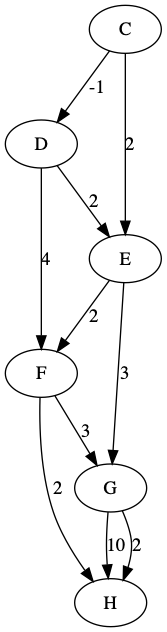

In [6]:
for tail, head, data in MultiGraph.edges(data=True):
    data['label'] = data['weight']
A = to_agraph(MultiGraph)
A.layout('dot')
A.draw('Original_Graph.png')
display_png(Image('Original_Graph.png'))

In [7]:
pred, distance = nx.dijkstra_predecessor_and_distance(MultiGraph.reverse(), source=target)

# shortest path tree
T = nx.MultiDiGraph()
for tail, heads in pred.items():
    if heads:
        head = heads[0]
        min_key = min(MultiGraph[tail][head], key=lambda key: MultiGraph[tail][head][key]['weight'])
        weight = MultiGraph[tail][head][min_key]['weight']
        T.add_edge(tail, head, weight=weight, key=min_key)

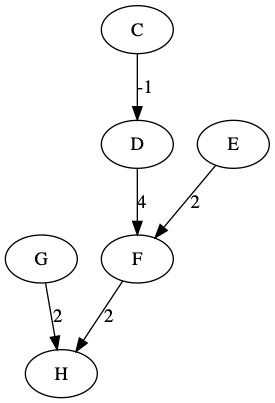

In [8]:
for tail, head, data in T.edges(data=True):
    data['label'] = data['weight']
A = to_agraph(T)
A.layout('dot')
A.draw('shortest_path_tree.png')
display_png(Image('Shortest_Path_Tree.png'))

In [9]:
for tail in MultiGraph:
    for head, edges in MultiGraph[tail].items():
        for key in edges:
            edges[key]['delta'] = edges[key]['weight'] + distance[head] - distance[tail]

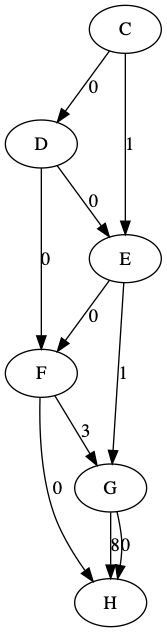

In [10]:
for tail, head, data in MultiGraph.edges(data=True):
    data['label'] = data['delta']
A = to_agraph(MultiGraph)
A.layout('dot')
A.draw('Potential_Graph.png')
display_png(Image('Potential_Graph.png'))

In [11]:
def out(v, MultiGraph, T):
    out_edges = []
    for head, edges in MultiGraph[v].items():
        for key in edges:
            if head not in T[v] or key not in T[v][head]:
                out_edges.append((v, head, key))
    return out_edges

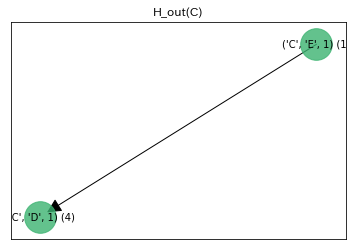

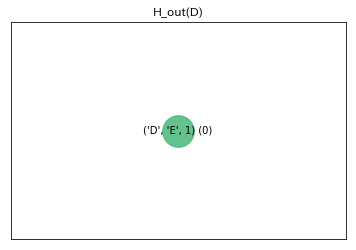

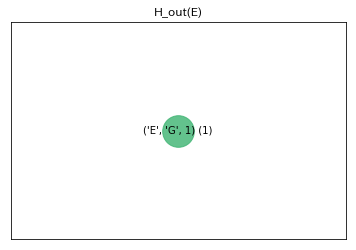

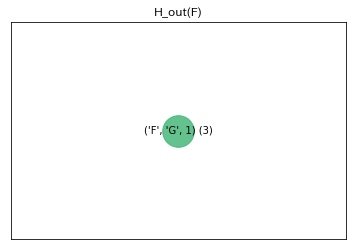

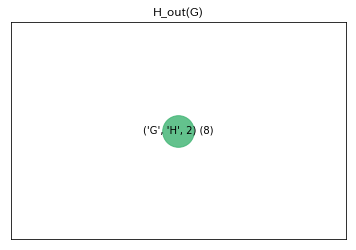

In [12]:
# generate H_out tree
for v in MultiGraph:
    out_edges = sorted(out(v, MultiGraph, T))
    h_out_tree = BinaryTree()
    if out_edges:
        max_root, *other_edges = out_edges
        for edge in other_edges:
            h_out_tree.insert(edge, MultiGraph.edges[edge]['delta'])
        h_out_tree.insert(max_root, MultiGraph.edges[max_root]['delta'])
    MultiGraph.node[v]['H_out'] = h_out_tree
for v in MultiGraph:
    MultiGraph.node[v]['H_out'].draw_tree(title=f"H_out({v})")

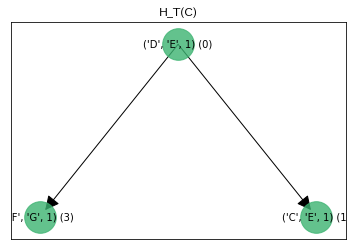

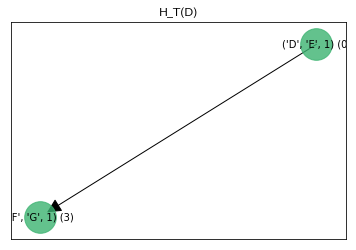

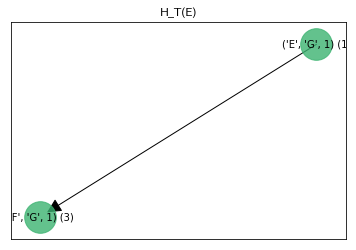

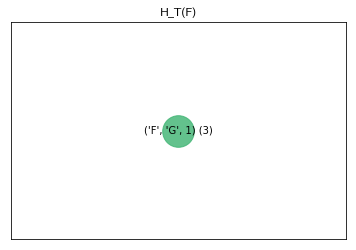

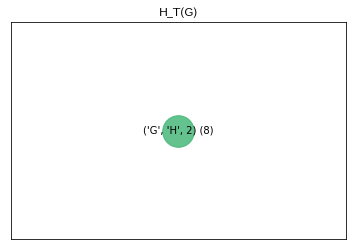

In [13]:
# generate H_T tree
h_t_tree = BinaryTree()
out_root = MultiGraph.node[target]['H_out'].root
if out_root is not None:
    h_t_tree.insert(out_root.name, out_root.value)
MultiGraph.node[target]['H_T'] = h_t_tree
for edge in nx.bfs_edges(T.reverse(), source=target):
    tail, head = edge
    h_t_tree = deepcopy(MultiGraph.node[tail]['H_T'])
    out_root = MultiGraph.node[head]['H_out'].root
    if out_root is not None:
        h_t_tree.insert(out_root.name, out_root.value)
    MultiGraph.node[head]['H_T'] = h_t_tree
for v in MultiGraph:
    MultiGraph.node[v]['H_T'].draw_tree(title=f"H_T({v})")

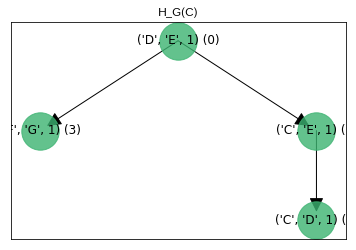

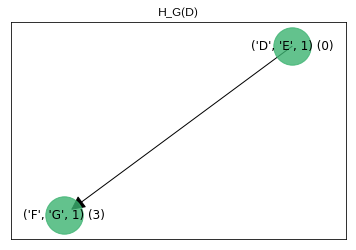

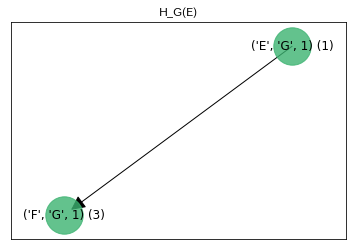

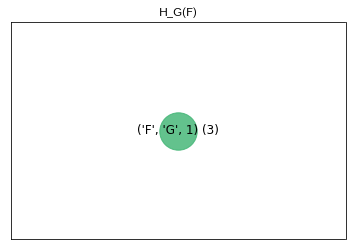

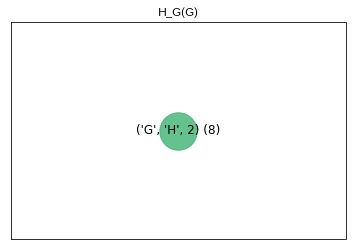

In [14]:
# generate H_G tree
h_g_tree = deepcopy(MultiGraph.node[target]['H_T'])
h_g_tree.h_out_insert(MultiGraph.node[target]['H_out'])
MultiGraph.node[target]['H_G'] = h_g_tree
for edge in nx.bfs_edges(T.reverse(), source=target):
    _, child = edge
    h_g_tree = MultiGraph.node[child]['H_T']
    for v in nx.shortest_path(T, source=child, target=target):
        h_g_tree.h_out_insert(MultiGraph.node[v]['H_out'])
    MultiGraph.node[child]['H_G'] = h_g_tree
for v in MultiGraph:
    MultiGraph.node[v]['H_G'].draw_tree2(title=f"H_G({v})")

In [15]:
# generate path-graph P
def edge2delta(MultiGraph, edge):
    tail, head, key = edge
    return MultiGraph[tail][head][key]['delta']
def add_H_G_to_P(P, node):
    for v in MultiGraph.node[node]['H_G'].traverse():
        v_name = (node, v.name)
        P.add_node(v_name)
        if v.left  is not None:
            u_name = (node, v.left.name)
            weight = edge2delta(MultiGraph, v.left.name) - edge2delta(MultiGraph, v.name)
            P.add_edge(v_name, u_name, weight=weight, edge_type='heap_edge')
        if v.right is not None:
            u_name = (node, v.right.name)
            weight = edge2delta(MultiGraph, v.right.name) - edge2delta(MultiGraph, v.name)
            P.add_edge(v_name, u_name, weight=weight, edge_type='heap_edge')
        if v.h_out is not None:
            u_name = (node, v.h_out.name)
            weight = edge2delta(MultiGraph, v.h_out.name) - edge2delta(MultiGraph, v.name)
            P.add_edge(v_name, u_name, weight=weight, edge_type='heap_edge')
    return P

## add heap edges
P = nx.DiGraph()    
P = add_H_G_to_P(P, target)
for edge in nx.bfs_edges(T.reverse(), source=target):
    _, child = edge
    P = add_H_G_to_P(P, child)
    
## add cross edges
for v in P:
    _, edge = v
    tail, head, key = edge
    if head not in T[tail] or key not in T[tail][head]:
        _, w, key = edge
        if MultiGraph.node[w]['H_G'].root is not None:
            u_name = (w, MultiGraph.node[w]['H_G'].root.name)
            weight = edge2delta(MultiGraph, MultiGraph.node[w]['H_G'].root.name)
            P.add_edge(v, u_name, weight=weight, edge_type='cross_edge')

## add root node
P.add_node('RootNode')
u = (source, MultiGraph.node[source]['H_G'].root.name)
weight = edge2delta(MultiGraph, MultiGraph.node[source]['H_G'].root.name)
P.add_edge('RootNode', u, weight=weight, edge_type='root_edge')

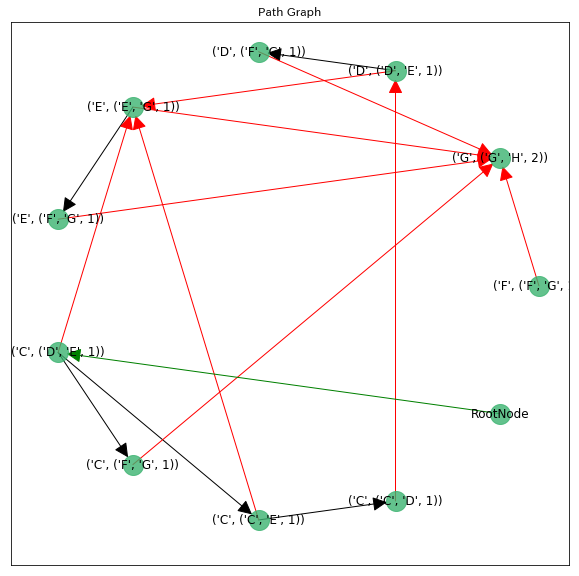

In [16]:
path_graph_pos = nx.shell_layout(P)
# path_graph_pos = nx.spring_layout(P)
labels = {v: v[1] for v in P}
labels['RootNode'] = 'RootNode'
plot_digraph3(P, pos=path_graph_pos, node_size=400, title='Path Graph', figsize=(10, 10), labels=None)

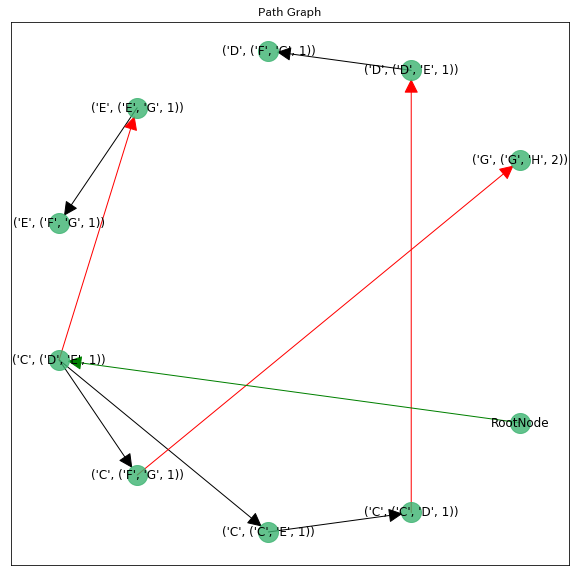

In [17]:
remain_edges = set()
for edge in nx.bfs_edges(P, source='RootNode'):
    remain_edges.add(edge)
plot_digraph3(P.edge_subgraph(remain_edges), pos=path_graph_pos, node_size=400, title='Path Graph', figsize=(10, 10), labels=None)

In [18]:
# find K - shortest path
def sidetracks2path(sidetracks, P, T, source, target, minus_weight):
    tmp_T = T.copy()
    for v, u in sidetracks[1:]:
        if P[v][u]['edge_type'] == 'cross_edge':
            tail, head, key = v[1]
            tmp_T.add_edge(tail, head, key=key, weight=minus_weight)
    if len(sidetracks) > 1:
        _, last_sidetracks = sidetracks[-1]
        tail, head, key = last_sidetracks[1]
        tmp_T.add_edge(tail, head, key=key, weight=minus_weight)
    plot_digraph(tmp_T, pos, title='Shortest Path Tree')
    shortest_path_node = nx.shortest_path(tmp_T, source=source, target=target, weight='weight')
    shortest_path_edge = []
    for tail, head in zip(shortest_path_node, shortest_path_node[1:]):
        min_key = min(tmp_T[tail][head], key=lambda key: tmp_T[tail][head][key]['weight'])
        shortest_path_edge.append((tail, head, min_key))
    return shortest_path_edge

[('C', 'D', 2), ('D', 'F', 1), ('F', 'H', 1)] 5
[('C', 'D', 2), ('D', 'E', 1), ('E', 'F', 1), ('F', 'H', 1)] 5
[('C', 'E', 1), ('E', 'F', 1), ('F', 'H', 1)] 6
[('C', 'D', 2), ('D', 'E', 1), ('E', 'G', 1), ('G', 'H', 1)] 6
[('C', 'E', 1), ('E', 'G', 1), ('G', 'H', 1)] 7
[('C', 'D', 2), ('D', 'F', 1), ('F', 'G', 1), ('G', 'H', 1)] 8
[('C', 'D', 2), ('D', 'E', 1), ('E', 'F', 1), ('F', 'G', 1), ('G', 'H', 1)] 8
[('C', 'D', 1), ('D', 'F', 1), ('F', 'H', 1)] 9
[('C', 'D', 1), ('D', 'E', 1), ('E', 'F', 1), ('F', 'H', 1)] 9
[('C', 'E', 1), ('E', 'F', 1), ('F', 'G', 1), ('G', 'H', 1)] 9
[('C', 'D', 1), ('D', 'E', 1), ('E', 'G', 1), ('G', 'H', 1)] 10
[('C', 'D', 1), ('D', 'F', 1), ('F', 'G', 1), ('G', 'H', 1)] 12
[('C', 'D', 1), ('D', 'E', 1), ('E', 'F', 1), ('F', 'G', 1), ('G', 'H', 1)] 12
[('C', 'D', 2), ('D', 'E', 1), ('E', 'G', 1), ('G', 'H', 2)] 14
[('C', 'E', 1), ('E', 'G', 1), ('G', 'H', 2)] 15
[('C', 'D', 2), ('D', 'F', 1), ('F', 'G', 1), ('G', 'H', 2)] 16
[('C', 'D', 2), ('D', 'E', 1), 

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


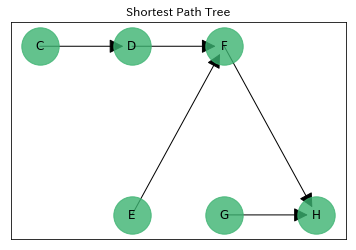

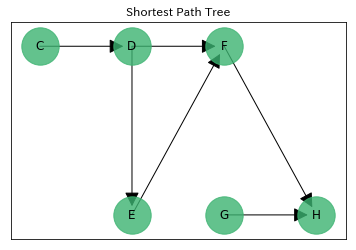

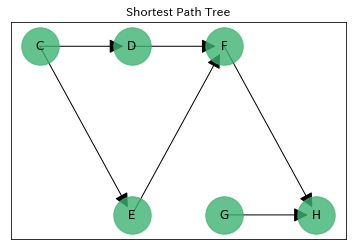

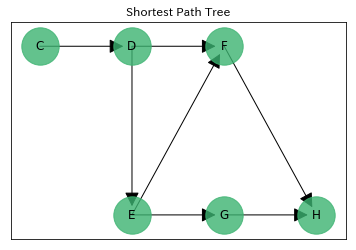

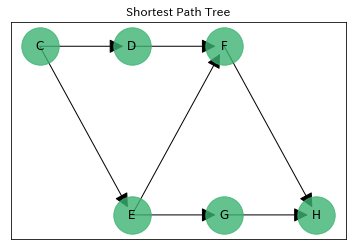

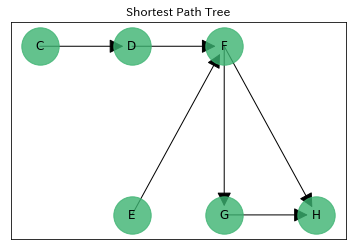

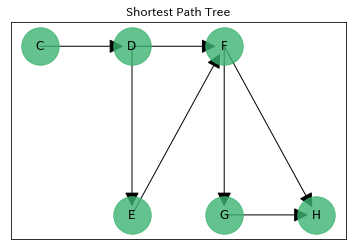

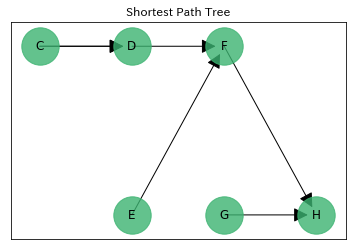

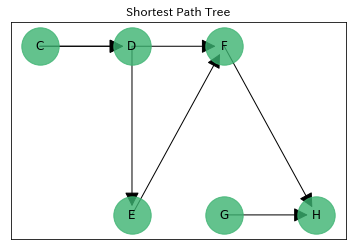

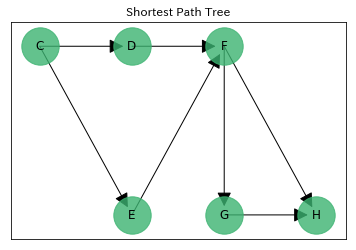

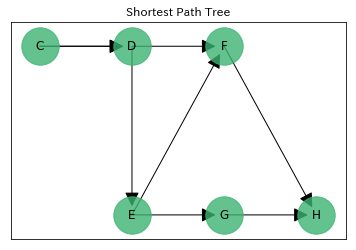

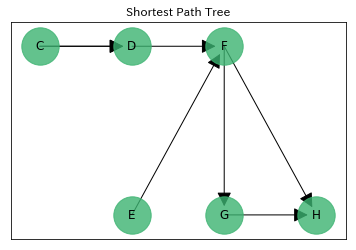

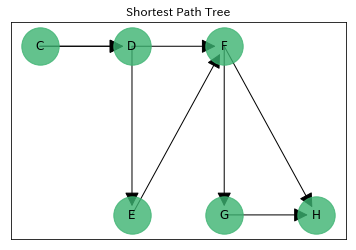

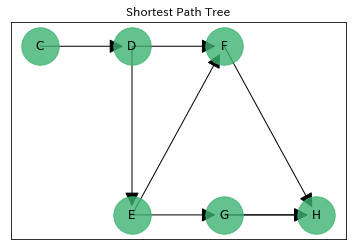

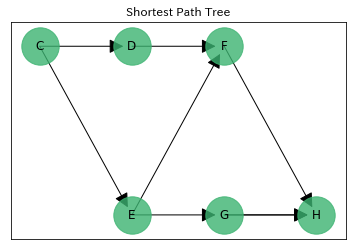

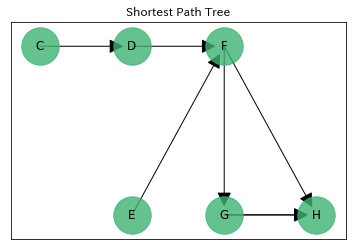

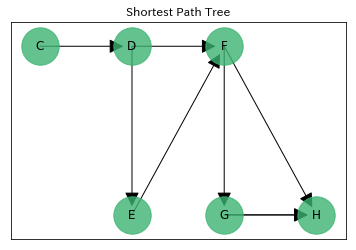

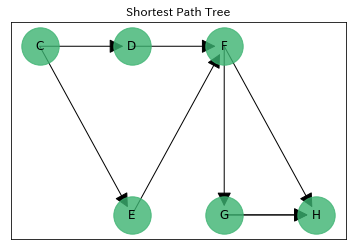

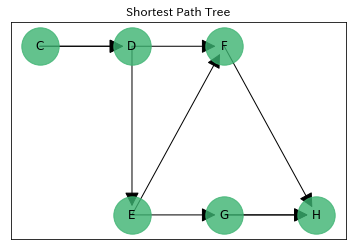

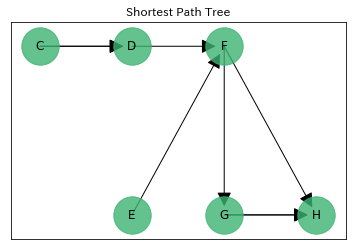

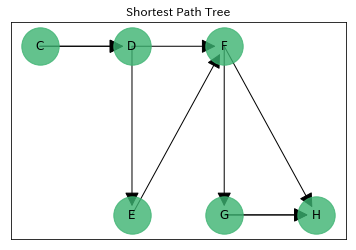

In [19]:
minus_weight = -sum(abs(edge_data['weight']) for tail, head in T.edges() for edge_data in T[tail][head].values())
A = [] #  パス格納
B = [(0, [(None, 'RootNode')])] # 幅優先用キュー
k = 0
while B and k < K:
    potentials, sidetracks = heappop(B)
    A.append(sidetracks2path(sidetracks, P, T, source, target, minus_weight))
    _, last_sidetracks = sidetracks[-1]
    for v in P[last_sidetracks]:
        new_sidetracks = sidetracks + [(last_sidetracks, v)]
        new_potentials = potentials + P.edges[last_sidetracks, v]['weight']
        heappush(B, (new_potentials, new_sidetracks))
    k = k + 1
    if k == 1:
        shortest_path_length = sum(MultiGraph[v][u][k]['weight'] for v, u, k in A[-1])
    length = shortest_path_length + potentials
    print(A[-1], length)